In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

Всё как обычно, но сегодня исследуем `XGBoost`, по сути пробегусь по [интро](https://xgboost.readthedocs.io/en/latest/python/python_intro.html) 

In [2]:
data = pd.read_csv('../04_Forests/HW/data/train.csv')

In [3]:
def preprocess(df: pd.DataFrame()) -> pd.DataFrame():
    out = df.copy()
    out.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
    
    cleanup_sex = {"Sex": {"male": 1, "female": 0}}
    out.replace(cleanup_sex, inplace=True)
    
    out = pd.get_dummies(out, columns=["Embarked"])
    
    out['Age'].fillna((out['Age'].mean()), inplace=True)
    return out

In [4]:
data_1 = preprocess(data)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support

In [25]:
x = data_1.drop(columns=['Survived'])
y = data_1['Survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

StandardScaler()

Ну всё, теперь можно кастовать `xgb`. Запихиваем данные в кучу

In [26]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

Определяем пареметры, как на [сайте](https://xgboost.readthedocs.io/en/latest/python/python_intro.html) 

In [27]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}

In [28]:
num_round = 10
bst = xgb.train(param, dtrain, num_round)

Сделали `fit`, пора и `predict`

In [29]:
y_test_hat = bst.predict(dtest)
y_train_hat = bst.predict(dtrain)

Только это нужно ещё и в {0, 1} отобразить

In [30]:
y_test_hat  = y_test_hat > 0.5  
y_test_hat = y_test_hat.astype(int) 

y_train_hat  = y_train_hat > 0.5  
y_train_hat = y_train_hat.astype(int)  

In [31]:
pr, rec, f1, _ = precision_recall_fscore_support(y_test, y_test_hat, average='binary')
print(f'Test\n\tprecision={pr:.2f}\n\trecall   ={rec:.2f}\n\tf1       ={f1:.2f}')
pr, rec, f1, _ = precision_recall_fscore_support(y_train, y_train_hat, average='binary')
print(f'Train\n\tprecision={pr:.2f}\n\trecall   ={rec:.2f}\n\tf1       ={f1:.2f}')

Test
	precision=0.84
	recall   =0.72
	f1       =0.77
Train
	precision=0.90
	recall   =0.68
	f1       =0.77


Так, `random_forest` показал 0.79.

А мы тут ещё `eta`(aka learning rate) не подкрутили... Перспектив много. Ещё глубину подкрутим. На лекции было сказано, что это долго, будем подбирать по очереди

In [24]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

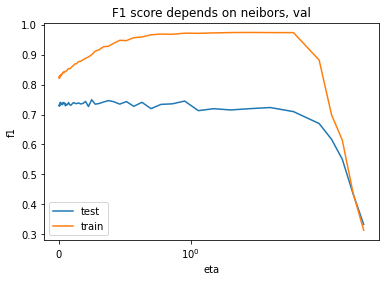

In [50]:
#'''
etas = np.logspace(np.log(1e-4), np.log(3), 100, base=np.exp(1))
f1_test_scores = []
f1_train_scores = []
for eta in etas:
    args = {'max_depth': 10, 'learning_rate': eta, 'n_estimators': 20}
    model = xgb.XGBClassifier(**args)
    scores = cross_validate(model, x_train, y_train, cv=5, scoring=make_scorer(f1_score), return_train_score=True)
    f1_test_scores.append(scores['test_score'].mean())
    f1_train_scores.append(scores['train_score'].mean())
_d = pd.DataFrame()
_d['etas'] = etas
_d['f1'] = f1_test_scores
_d.to_csv('cv_data/eta_test.csv')
_d = pd.DataFrame()
_d['etas'] = etas
_d['f1'] = f1_train_scores
_d.to_csv('cv_data/eta_train.csv')
#'''
_d = pd.read_csv('cv_data/eta_test.csv', index_col=0)
etas = _d['etas']
f1_test_scores = _d['f1']
_d = pd.read_csv('cv_data/eta_train.csv', index_col=0)
f1_train_scores = _d['f1']

plt.plot(etas, f1_test_scores, label='test')
plt.plot(etas, f1_train_scores, label='train')
plt.xlabel('eta')
plt.xscale('symlog')
plt.ylabel('f1')
plt.title('F1 score depends on neibors, val')
plt.legend()
plt.show()

Теперь подберём `n_estimators`

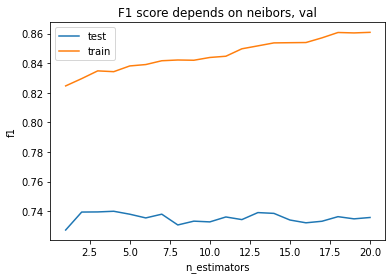

In [60]:
#'''
ns = np.linspace(1, 20, 20, dtype=int)
f1_test_scores = []
f1_train_scores = []
for n in ns:
    args = {'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': n}
    model = xgb.XGBClassifier(**args)
    scores = cross_validate(model, x_train, y_train, cv=5, scoring=make_scorer(f1_score), return_train_score=True)
    f1_test_scores.append(scores['test_score'].mean())
    f1_train_scores.append(scores['train_score'].mean())
_d = pd.DataFrame()
_d['ns'] = ns
_d['f1'] = f1_test_scores
_d.to_csv('cv_data/eta_test1.csv')
_d = pd.DataFrame()
_d['ns'] = ns
_d['f1'] = f1_train_scores
_d.to_csv('cv_data/eta_train1.csv')
#'''
_d = pd.read_csv('cv_data/eta_test1.csv', index_col=0)
ns = _d['ns']
f1_test_scores = _d['f1']
_d = pd.read_csv('cv_data/eta_train1.csv', index_col=0)
f1_train_scores = _d['f1']

plt.plot(ns, f1_test_scores, label='test')
plt.plot(ns, f1_train_scores, label='train')
plt.xlabel('n_estimators')
plt.ylabel('f1')
plt.title('F1 score depends on neibors, val')
plt.legend()
plt.show()

А теперь глубину

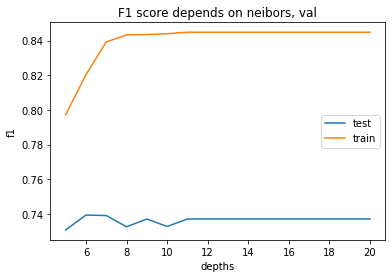

In [63]:
#'''
depths = np.linspace(5, 20, 16, dtype=int)
f1_test_scores = []
f1_train_scores = []
for d in depths:
    args = {'max_depth': d, 'learning_rate': 0.1, 'n_estimators': 10}
    model = xgb.XGBClassifier(**args)
    scores = cross_validate(model, x_train, y_train, cv=5, scoring=make_scorer(f1_score), return_train_score=True)
    f1_test_scores.append(scores['test_score'].mean())
    f1_train_scores.append(scores['train_score'].mean())
_d = pd.DataFrame()
_d['depths'] = depths
_d['f1'] = f1_test_scores
_d.to_csv('cv_data/eta_test2.csv')
_d = pd.DataFrame()
_d['depths'] = depths
_d['f1'] = f1_train_scores
_d.to_csv('cv_data/eta_train2.csv')
#'''
_d = pd.read_csv('cv_data/eta_test2.csv', index_col=0)
depths = _d['depths']
f1_test_scores = _d['f1']
_d = pd.read_csv('cv_data/eta_train2.csv', index_col=0)
f1_train_scores = _d['f1']

plt.plot(depths, f1_test_scores, label='test')
plt.plot(depths, f1_train_scores, label='train')
plt.xlabel('depths')
plt.ylabel('f1')
plt.title('F1 score depends on neibors, val')
plt.legend()
plt.show()

Соберём "лучший" набор параметров

In [64]:
args = {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 10}
model = xgb.XGBClassifier(**args)

In [65]:
y_test_hat = bst.predict(dtest)
y_train_hat = bst.predict(dtrain)

In [67]:
y_test_hat  = y_test_hat > 0.5  
y_test_hat = y_test_hat.astype(int) 

y_train_hat  = y_train_hat > 0.5  
y_train_hat = y_train_hat.astype(int)  

In [68]:
pr, rec, f1, _ = precision_recall_fscore_support(y_test, y_test_hat, average='binary')
print(f'Test\n\tprecision={pr:.2f}\n\trecall   ={rec:.2f}\n\tf1       ={f1:.2f}')
pr, rec, f1, _ = precision_recall_fscore_support(y_train, y_train_hat, average='binary')
print(f'Train\n\tprecision={pr:.2f}\n\trecall   ={rec:.2f}\n\tf1       ={f1:.2f}')

Test
	precision=0.84
	recall   =0.72
	f1       =0.77
Train
	precision=0.90
	recall   =0.68
	f1       =0.77


Чучуть не дотягивает до случайных лесов, зато почт не переобучается